# A look into LT meteo data

In [46]:
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import pycircular

def standard_angle(angle: float) -> float:
    """
    Takes an angle in radians and returns it in the interval 0, 2*pi
    
    :param angle: Angle to be standardised, in radians.
    :return: An equivalent angle in the interval 0, 2*pi
    """
    if (angle > 2*np.pi) or (angle < 0)
        return angle%(2*np.pi)
    else:
        return angle

In [47]:
data_path = "../data/meteo_lt.dat"
col_names = ["date", "wms_status", "rain_flag", "moisture_flag", "truss_temp", "oil_temp", "wind_speed", "wind_direction", "ambient_temp", "dew_point", "humidity", "air_pressure", "light"]
df1 = pd.read_csv(data_path, sep=" ", names = col_names, parse_dates=[0], date_format="%Y-%m-%d%H:%M:%SUTC")
df1["wind_direction_radians"] = df1["wind_direction"].apply(lambda x: standard_angle(np.radians(x)))
    

In [48]:
df1

,date,wms_status,rain_flag,moisture_flag,truss_temp,oil_temp,wind_speed,wind_direction,ambient_temp,dew_point,humidity,air_pressure,light,wind_direction_radians
0,2022-01-01 00:02:02,OKAY,CLEAR,0.05,8.63,9.5,5.1,188.0,8.9,-12.70,0.20,778.0,1.2,3.281219
1,2022-01-01 00:03:59,OKAY,CLEAR,0.05,8.65,9.1,4.4,184.0,9.0,-13.30,0.19,778.0,1.5,3.211406
2,2022-01-01 00:05:55,OKAY,CLEAR,0.05,8.72,9.5,3.8,217.0,9.1,-13.70,0.18,778.0,1.4,3.787364
3,2022-01-01 00:08:02,OKAY,CLEAR,0.05,8.79,9.5,3.3,197.0,9.2,-13.20,0.19,778.0,1.6,3.438299
4,2022-01-01 00:09:58,OKAY,CLEAR,0.05,8.84,9.3,3.4,192.0,9.4,-13.30,0.19,778.0,1.6,3.351032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503105,2024-04-30 13:47:57,WARN,CLEAR,0.00,0.00,11.8,4.2,52.0,10.2,-7.53,0.28,775.0,798.0,0.907571
503106,2024-04-30 13:50:02,WARN,CLEAR,0.00,0.00,12.0,1.4,21.0,10.4,-8.17,0.26,775.0,798.0,0.366519
503107,2024-04-30 13:51:59,WARN,CLEAR,0.00,0.00,11.8,3.5,75.0,10.5,-8.33,0.26,775.0,798.0,1.308997
503108,2024-04-30 13:53:54,WARN,CLEAR,0.00,0.00,11.8,4.7,49.0,10.5,-6.33,0.30,775.0,798.0,0.855211


## Wind speed distribution

Text(0.5, 0, 'Wind speed (m/s)')

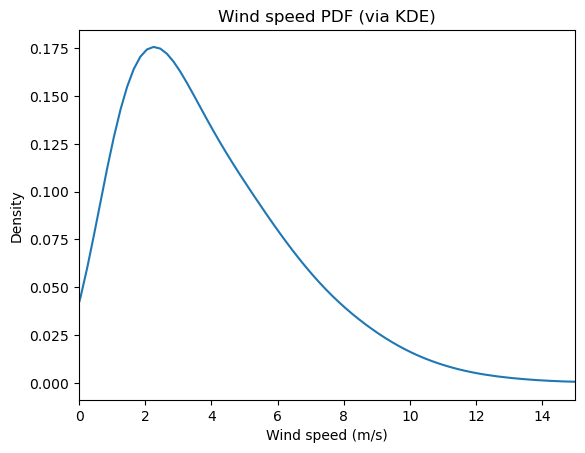

In [4]:
df1["wind_speed"].plot.kde(xlim=(0, 15), title="Wind speed PDF (via KDE)")
plt.xlabel(xlabel="Wind speed (m/s)")

## Wind direction distribution

A polar scatter plot can help us visualise the most frequent wind speed and directions.

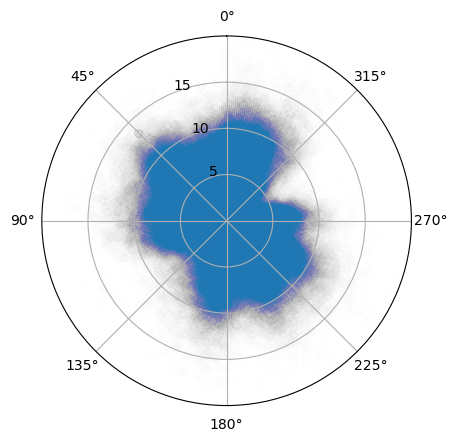

In [80]:
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter(df1["wind_direction_radians"], df1["wind_speed"], alpha=0.005)
ax.set_rmax(20)
ax.set_rticks([5, 10, 15])
ax.set_theta_zero_location('N')

To get an idea of the density of the data, we can use a density estimator to approximate a continuous PDF, this is, a function $p$ such that $$\int_0^{2\pi} p(\theta) d\theta = 1$$ and $$\int_{\theta_1}^{\theta_2} p(\theta) d\theta$$ gives the probability of the wind direction being in the interval $[\theta_1, \theta_2]$.

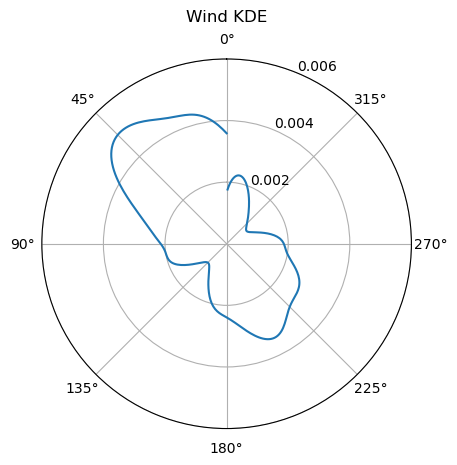

In [78]:
kde = scipy.stats.gaussian_kde(df1["wind_direction"])
theta = np.arange(0, 360, 1)
r = kde(theta)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta/360*2*np.pi, r)
ax.set_rmax(0.006)
ax.set_rticks([0.002, 0.004, 0.006])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)
ax.set_theta_zero_location('N')
ax.set_title("Wind KDE", va='bottom')
plt.show()

Linear KDE is not applicable because our data is angular and, therefore, modular (see the discontinuity of the KDE at $\theta = 0\;\text{deg}$). There aren't many tools designed to do KDE analysis on circular data. We try the `pycircular` package.

We first select a sample to calculate the bandwith.

In [67]:
wind_sample = df1["wind_direction_radians"].sample(n=2000).tolist()
wind_sample
bw = pycircular.circular.bwEstimation(wind_sample)
print(bw)

60.43072419396088


In [68]:
circular_kde = pycircular.circular.kernel(df1["wind_direction_radians"], bw=bw, n=256)

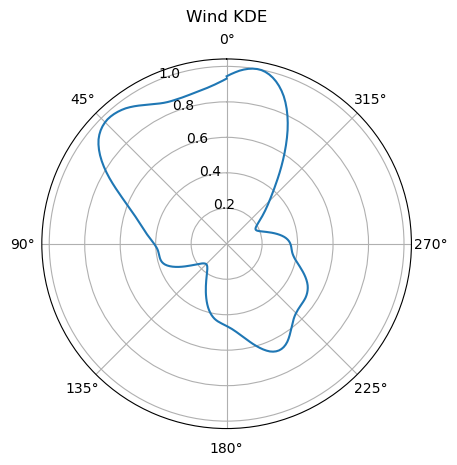

In [74]:
x = np.linspace(0, 2*np.pi, 256)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location('N')
ax.set_title("Wind KDE", va='bottom')
ax.plot(x, circular_kde)

https://gist.github.com/jobovy/a10a97353b8200b397de1f35a6525ece

# Comparison of LT and NRT data

In [15]:
!pip install influxdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 kB 3.8 MB/s eta 0:00:00


In [16]:
from influxdb import InfluxDBClient

In [18]:
client = InfluxDBClient(host='https://influxdb.services.newrobotictelescope.org/', port=8086, username='nrt-admin', password='super_secret_password', ssl=True, verify_ssl=True)

In [22]:
client.switch_database("Weatherstation1")

In [23]:
client.get_list_database()

ConnectionError: HTTPSConnectionPool(host='https', port=443): Max retries exceeded with url: //influxdb.services.newrobotictelescope.org/:8086/query?q=SHOW+DATABASES&db=Weatherstation1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x14bf8b090>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))